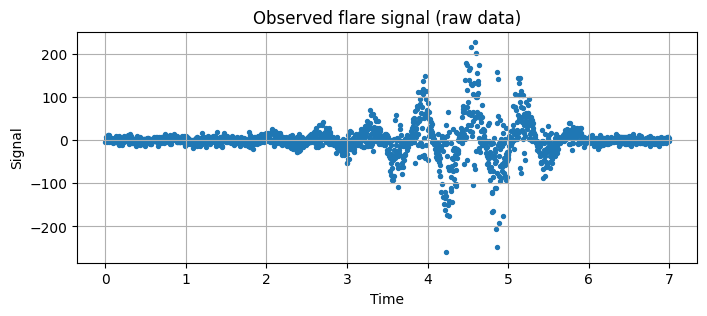

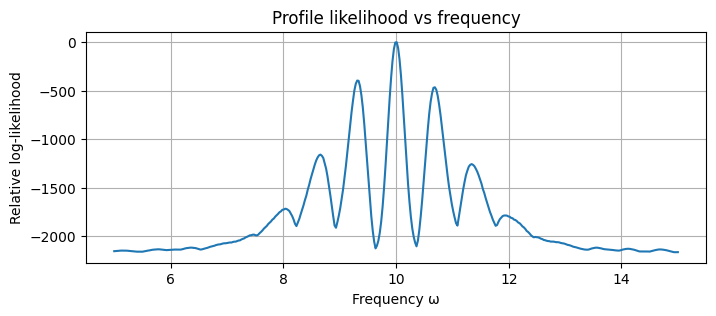

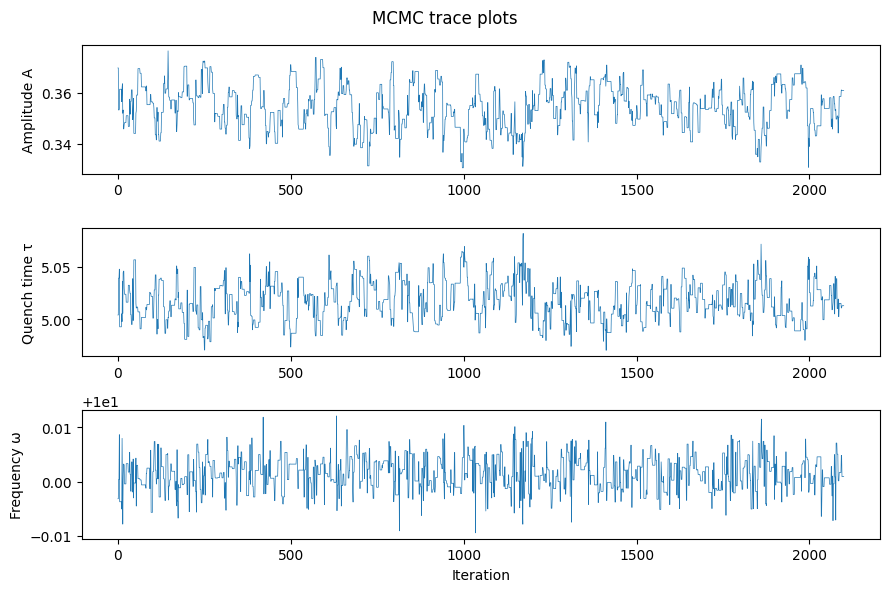

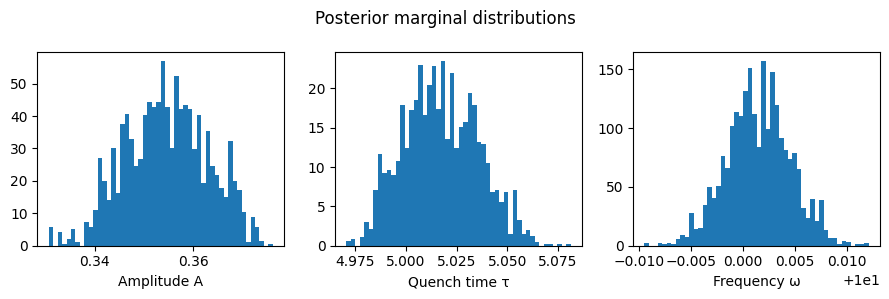

MAP estimates:
A     = 0.3537
tau   = 5.0209
omega = 10.0014


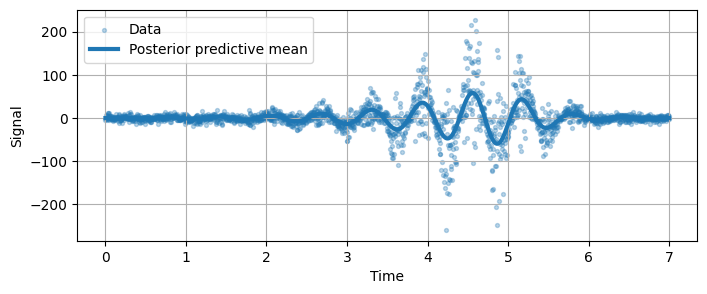

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

def load_data(path="flare_data.csv"):
	data = pd.read_csv(path)
	return data["t"].values, data["s"].values

def basis(t, tau, omega):
	return np.exp(t) * (1 - np.tanh(2 * (t - tau))) * np.sin(omega * t)

def model(t, A, tau, omega):
	return A * basis(t, tau, omega)

def compute_sigma2(y, floor_frac=0.3, sigma0=2.0):
	y_peak = np.max(np.abs(y))
	y_floor = floor_frac * y_peak
	sigma_rel = 0.2 * np.maximum(np.abs(y), y_floor)
	return sigma_rel**2 + sigma0**2

def optimal_A(g, y, sigma2):
	num = np.sum(y * g / sigma2)
	den = np.sum(g * g / sigma2)
	return num / den if den > 0 else 0.0

def profile_tau_omega(t, y, sigma2, tau_grid, omega_grid):
	profile_L = np.full(len(omega_grid), -np.inf)
	best_tau = np.zeros(len(omega_grid))

	for i, omega in enumerate(omega_grid):
		for tau in tau_grid:
			g = basis(t, tau, omega)
			A_star = optimal_A(g, y, sigma2)
			res = y - A_star * g
			L = -np.sum(res**2 / sigma2)
			if L > profile_L[i]:
				profile_L[i] = L
				best_tau[i] = tau
	return profile_L, best_tau

def log_likelihood(theta, t, y, sigma2):
	A, tau, omega = theta
	S = model(t, A, tau, omega)
	return -np.sum((y - S)**2 / sigma2)

def log_prior(theta):
	A, tau, omega = theta
	if not (0 < A < 2): return -np.inf
	if not (1 < tau < 10): return -np.inf
	if not (1 < omega < 20): return -np.inf
	return 0.0

def log_posterior(theta, t, y, sigma2):
	lp = log_prior(theta)
	if not np.isfinite(lp):
		return -np.inf
	return lp + log_likelihood(theta, t, y, sigma2)

def run_mcmc(init_theta, t, y, sigma2, n_steps=30000):
	A, tau, omega = init_theta
	logP = log_posterior([A, tau, omega], t, y, sigma2)
	samples = np.zeros((n_steps, 3))
	accepted = 0

	for i in range(n_steps):
		A_prop = A * np.exp(0.02 * np.random.randn())
		tau_prop = tau + 0.03 * np.random.randn()
		omega_prop = omega + 0.04 * np.random.randn()
		prop = [A_prop, tau_prop, omega_prop]
		logP_new = log_posterior(prop, t, y, sigma2)
		if np.log(np.random.rand()) < (logP_new - logP):
			A, tau, omega = prop
			logP = logP_new
			accepted += 1
		samples[i] = [A, tau, omega]

	return samples, accepted / n_steps

def posterior_predictive_mean(samples, t_plot, n_draws=1000):
	idx = np.random.choice(len(samples), n_draws, replace=False)
	S = np.zeros_like(t_plot)
	for i in idx:
		S += model(t_plot, *samples[i])
	return S / n_draws


t, y = load_data()
sigma2 = compute_sigma2(y)

plt.figure(figsize=(8,3))
plt.scatter(t, y, s=8)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Observed flare signal (raw data)")
plt.grid(True)
plt.show()

tau_grid = np.linspace(2, 8, 40)
omega_grid = np.linspace(5, 15, 400)

profile_L, best_tau = profile_tau_omega(t, y, sigma2, tau_grid, omega_grid)

plt.figure(figsize=(8,3))
plt.plot(omega_grid, profile_L - np.max(profile_L))
plt.xlabel("Frequency ω")
plt.ylabel("Relative log-likelihood")
plt.title("Profile likelihood vs frequency")
plt.grid(True)
plt.show()

idx = np.argmax(profile_L)
tau0 = best_tau[idx]
omega0 = omega_grid[idx]
A0 = optimal_A(basis(t, tau0, omega0), y, sigma2)

samples, acc_rate = run_mcmc([A0, tau0, omega0], t, y, sigma2)
samples = samples[int(0.3*len(samples))::10]

logPs = np.array([log_posterior(s, t, y, sigma2) for s in samples])
map_params = samples[np.argmax(logPs)]

labels = ["Amplitude A", "Quench time τ", "Frequency ω"]
plt.figure(figsize=(9,6))
for i in range(3):
	plt.subplot(3,1,i+1)
	plt.plot(samples[:,i], lw=0.5)
	plt.ylabel(labels[i])
plt.xlabel("Iteration")
plt.suptitle("MCMC trace plots")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,3))
for i in range(3):
	plt.subplot(1,3,i+1)
	plt.hist(samples[:,i], bins=50, density=True)
	plt.xlabel(labels[i])
plt.suptitle("Posterior marginal distributions")
plt.tight_layout()
plt.show()


print("MAP estimates:")
print(f"A     = {map_params[0]:.4f}")
print(f"tau   = {map_params[1]:.4f}")
print(f"omega = {map_params[2]:.4f}")
t_plot = np.linspace(t.min(), t.max(), 2000)
S_pred = posterior_predictive_mean(samples, t_plot)

plt.figure(figsize=(8,3))
plt.scatter(t, y, s=8, alpha=0.3, label="Data")
plt.plot(t_plot, S_pred, lw=3, label="Posterior predictive mean")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()
